Installing packages

In [ ]:
!pip install datasets --quiet
!pip install torch --quiet

Importing relevant packages

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import tqdm
import re

Load data for training

In [ ]:
def load_data(base_dir, layer):
    embeddings = []
    labels = []
    label_map = {}

    # Iterate over each speaker's directory
    for speaker_dir in os.listdir(base_dir):
        # Extract the speaker number from the directory name
        match = re.search(r'(\d+)', speaker_dir)
        if match:
            # Subtract 1 to shift labels from [1, 25] to [0, 24]
            label = int(match.group(1)) - 1

            # Build the path to the specific layer for the current speaker
            layer_dir = os.path.join(base_dir, speaker_dir, layer)

            if os.path.isdir(layer_dir) and 'no_overlap' in layer_dir:
                # Load all .npy files in this layer directory
                for file_name in os.listdir(layer_dir):
                    if file_name.endswith('.npy'):
                        path = os.path.join(layer_dir, file_name)
                        embedding = np.load(path)
                        embeddings.append(embedding)

                        # Append the label for each embedding
                        labels.append(label)

    # Convert list of embeddings and labels to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels

Creating model

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), padding=(2, 2))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 12 * 128, 128)  # Adjust the flattened size according to your input shape
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 12 * 128)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


Function to train und evaluate all layers by iterating over them.

In [ ]:
def evaluate_model(model, loader, device, male_indices, female_indices):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(targets.cpu().numpy())

    # Berechnung der Gesamtmetriken
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # Berechnung der Metriken für männliche Sprecher
    male_mask = np.isin(y_true, male_indices)
    male_accuracy = accuracy_score(np.array(y_true)[male_mask], np.array(y_pred)[male_mask])
    male_precision, male_recall, male_f1, _ = precision_recall_fscore_support(np.array(y_true)[male_mask], np.array(y_pred)[male_mask], average='weighted')

    # Berechnung der Metriken für weibliche Sprecher
    female_mask = np.isin(y_true, female_indices)
    female_accuracy = accuracy_score(np.array(y_true)[female_mask], np.array(y_pred)[female_mask])
    female_precision, female_recall, female_f1, _ = precision_recall_fscore_support(np.array(y_true)[female_mask], np.array(y_pred)[female_mask], average='weighted')

    return {
        'total': (accuracy, precision, recall, f1),
        'male': (male_accuracy, male_precision, male_recall, male_f1),
        'female': (female_accuracy, female_precision, female_recall, female_f1)
    }


In [ ]:
def train_and_evaluate(base_dir, layers, num_classes, male_indices, female_indices, device, epochs=30, weight_decay=0.01, test_size=0.2):
    torch.manual_seed(0)  # Setzen des Seeds für reproduzierbare Ergebnisse
    results = []
    for layer in layers:
        # Daten laden
        embeddings, labels = load_data(base_dir, layer)

        # Aufteilen in Trainings- und Testdatensätze
        X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=test_size, random_state=0)

        # Trainingsdatensatz vorbereiten
        train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        # Testdatensatz vorbereiten
        test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Modell initialisieren
        model = CNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=weight_decay)

        epoch_data = {'epoch': [], 'train_loss': [], 'train_accuracy': []}

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

            # Trainingsgenauigkeit berechnen
            train_accuracy = correct / total

            # Speichern der Trainingsmetriken
            epoch_data['epoch'].append(epoch)
            epoch_data['train_loss'].append(total_loss / len(train_loader))
            epoch_data['train_accuracy'].append(train_accuracy)

            print(f"Layer: {layer}, Epoch: {epoch+1}, Train Loss: {total_loss / len(train_loader)}, Train Accuracy: {train_accuracy}")

        # Evaluation auf dem Testdatensatz am Ende des Trainings
        test_metrics = evaluate_model(model, test_loader, device, male_indices, female_indices)
        print(f"Test Metrics: Total - {test_metrics['total']}, Male - {test_metrics['male']}, Female - {test_metrics['female']}")
        results.append((layer, epoch_data['train_loss'][-1], epoch_data['train_accuracy'][-1], test_metrics))

        # CSV-Datei mit den Trainingsergebnissen speichern
        df = pd.DataFrame(epoch_data)
        df.to_csv(f"/content/drive/My Drive/new_speaker_identification/evaluation/{layer}_training_progress.csv", index=False)

    return results

Saving results and training progress of each step into CSV file.

In [ ]:
def save_final_results(results, save_path):
    # Vorbereiten einer Liste für den DataFrame
    expanded_results = []
    for layer, train_loss, train_accuracy, test_metrics in results:
        expanded_results.append({
            'Layer': layer,
            'Train Loss': train_loss,
            'Train Accuracy': train_accuracy,
            'Test Accuracy Total': test_metrics['total'][0],
            'Test Precision Total': test_metrics['total'][1],
            'Test Recall Total': test_metrics['total'][2],
            'Test F1-Score Total': test_metrics['total'][3],
            'Test Accuracy Male': test_metrics['male'][0],
            'Test Precision Male': test_metrics['male'][1],
            'Test Recall Male': test_metrics['male'][2],
            'Test F1-Score Male': test_metrics['male'][3],
            'Test Accuracy Female': test_metrics['female'][0],
            'Test Precision Female': test_metrics['female'][1],
            'Test Recall Female': test_metrics['female'][2],
            'Test F1-Score Female': test_metrics['female'][3]
        })

    # Erstellen des DataFrame
    df_results = pd.DataFrame(expanded_results)
    df_results.to_csv(save_path, index=False)

Conducting training and evaluation

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Definition der Indizes für männliche und weibliche Sprecher
# male_indices = [15, 21, 24, 8, 23, 25, 22, 5, 10, 9]
# female_indices = [17, 16, 14, 13, 12, 11, 7, 6, 4, 3, 2, 1]

male_indices = [20, 19, 15, 21, 24, 8, 23, 25, 22, 5, 10, 9]
female_indices = [18, 17, 16, 14, 13, 12, 11, 7, 6, 4, 3, 2, 1]

# Reduzieren Sie jeden Index um 1, um den Bereich von 0 bis 24 zu erhalten
male_indices = [i - 1 for i in male_indices]
female_indices = [i - 1 for i in female_indices]

base_dir = '/content/drive/My Drive/new_speaker_identification/clips__test/'
layers = ['layer_0_no_overlap', 'layer_5_no_overlap', 'layer_10_no_overlap', 'layer_15_no_overlap', 'layer_20_no_overlap', 'layer_24_no_overlap']
num_classes = 25
results = train_and_evaluate(base_dir=base_dir, layers=layers, num_classes=num_classes, device=device, male_indices=male_indices, female_indices=female_indices)
save_final_results(results, '/content/drive/My Drive/new_speaker_identification/evaluation/final_results.csv')

### Logistic regression

Now trying to reproduce the trends with a way simpler model, using logistic regression.

first we need to flatten the input matrices, because logistic regression is not able to process matrices.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from tqdm import tqdm
import re

In [ ]:
def load_data(base_dir, layer):
    embeddings = []
    labels = []

    # Iterate over each speaker's directory
    for speaker_dir in os.listdir(base_dir):
        # Extract the speaker number from the directory name
        match = re.search(r'(\d+)', speaker_dir)
        if match:
            # Subtract 1 to shift labels from [1, 25] to [0, 24]
            label = int(match.group(1)) - 1

            # Build the path to the specific layer for the current speaker
            layer_dir = os.path.join(base_dir, speaker_dir, layer)

            if os.path.isdir(layer_dir) and 'no_overlap' in layer_dir:
                # Load all .npy files in this layer directory
                for file_name in os.listdir(layer_dir):
                    if file_name.endswith('.npy'):
                        path = os.path.join(layer_dir, file_name)
                        embedding = np.load(path)

                        # Flatten the embedding to a 1D array if it's not already
                        embedding = embedding.flatten()
                        embeddings.append(embedding)

                        # Append the label for each embedding
                        labels.append(label)

    # Convert list of embeddings and labels to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels


Now implementing the logistic regression training and evaluation.

In [ ]:
def train_and_evaluate(base_dir, layers, num_classes, male_indices, female_indices, epochs=30, test_size=0.2):
    results = []
    for layer in layers:
        # Daten laden (dies muss die Daten als 2D-Featurematrix zurückgeben)
        embeddings, labels = load_data(base_dir, layer)

        # Aufteilen in Trainings- und Testdatensätze
        X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=test_size, random_state=0)

        # Modell initialisieren (Logistische Regression)
        model = LogisticRegression(max_iter=epochs)

        # Modell trainieren
        model.fit(X_train, y_train)

        # Evaluation auf dem Testdatensatz am Ende des Trainings
        test_metrics = evaluate_model(model, X_test, y_test, male_indices, female_indices)
        print(f"Layer: {layer}, Test Metrics: {test_metrics}")

        # Ergebnisse speichern
        results.append((layer, test_metrics))

        # CSV-Datei mit den Trainingsergebnissen speichern
        df = pd.DataFrame(test_metrics)
        df.to_csv(f"/content/drive/My Drive/new_speaker_identification/evaluation/{layer}_training_progress.csv", index=False)

    return results

def evaluate_model(model, X_test, y_test, male_indices, female_indices):
    # Vorhersagen machen
    y_pred = model.predict(X_test)
    # Gesamtmetriken
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Metriken für männliche Sprecher
    male_mask = np.isin(y_test, male_indices)
    male_accuracy = accuracy_score(y_test[male_mask], y_pred[male_mask])
    male_precision, male_recall, male_f1, _ = precision_recall_fscore_support(y_test[male_mask], y_pred[male_mask], average='weighted')

    # Metriken für weibliche Sprecher
    female_mask = np.isin(y_test, female_indices)
    female_accuracy = accuracy_score(y_test[female_mask], y_pred[female_mask])
    female_precision, female_recall, female_f1, _ = precision_recall_fscore_support(y_test[female_mask], y_pred[female_mask], average='weighted')

    return {
        'total': {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1},
        'male': {'accuracy': male_accuracy, 'precision': male_precision, 'recall': male_recall, 'f1': male_f1},
        'female': {'accuracy': female_accuracy, 'precision': female_precision, 'recall': female_recall, 'f1': female_f1}
    }

# Anpassen der Datenladefunktion und anderer benötigter Komponenten entsprechend

In [ ]:
def save_final_results(results, save_path):
    # Vorbereiten einer Liste für den DataFrame
    expanded_results = []
    for layer, metrics in results:
        expanded_results.append({
            'Layer': layer,
            'Test Accuracy Total': metrics['total']['accuracy'],
            'Test Precision Total': metrics['total']['precision'],
            'Test Recall Total': metrics['total']['recall'],
            'Test F1-Score Total': metrics['total']['f1'],
            'Test Accuracy Male': metrics['male']['accuracy'],
            'Test Precision Male': metrics['male']['precision'],
            'Test Recall Male': metrics['male']['recall'],
            'Test F1-Score Male': metrics['male']['f1'],
            'Test Accuracy Female': metrics['female']['accuracy'],
            'Test Precision Female': metrics['female']['precision'],
            'Test Recall Female': metrics['female']['recall'],
            'Test F1-Score Female': metrics['female']['f1']
        })

    # Erstellen des DataFrame
    df_results = pd.DataFrame(expanded_results)
    df_results.to_csv(save_path, index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

results = train_and_evaluate(
    base_dir='/content/drive/My Drive/new_speaker_identification/clips__test/',
    layers=[
        'layer_0_no_overlap', 'layer_5_no_overlap', 'layer_10_no_overlap',
        'layer_15_no_overlap', 'layer_20_no_overlap', 'layer_24_no_overlap'
    ],
    num_classes=25,
    male_indices=[i - 1 for i in [20, 19, 15, 21, 24, 8, 23, 25, 22, 5, 10, 9]],  # Indizes angepasst
    female_indices=[i - 1 for i in [18, 17, 16, 14, 13, 12, 11, 7, 6, 4, 3, 2, 1]],  # Indizes angepasst
    epochs=100,
    test_size=0.2
)

# Speichern der Resultate
save_final_results(
    results,
    '/content/drive/My Drive/new_speaker_identification/evaluation/final_results.csv'
)

Plotting the results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Evaluation CNN:

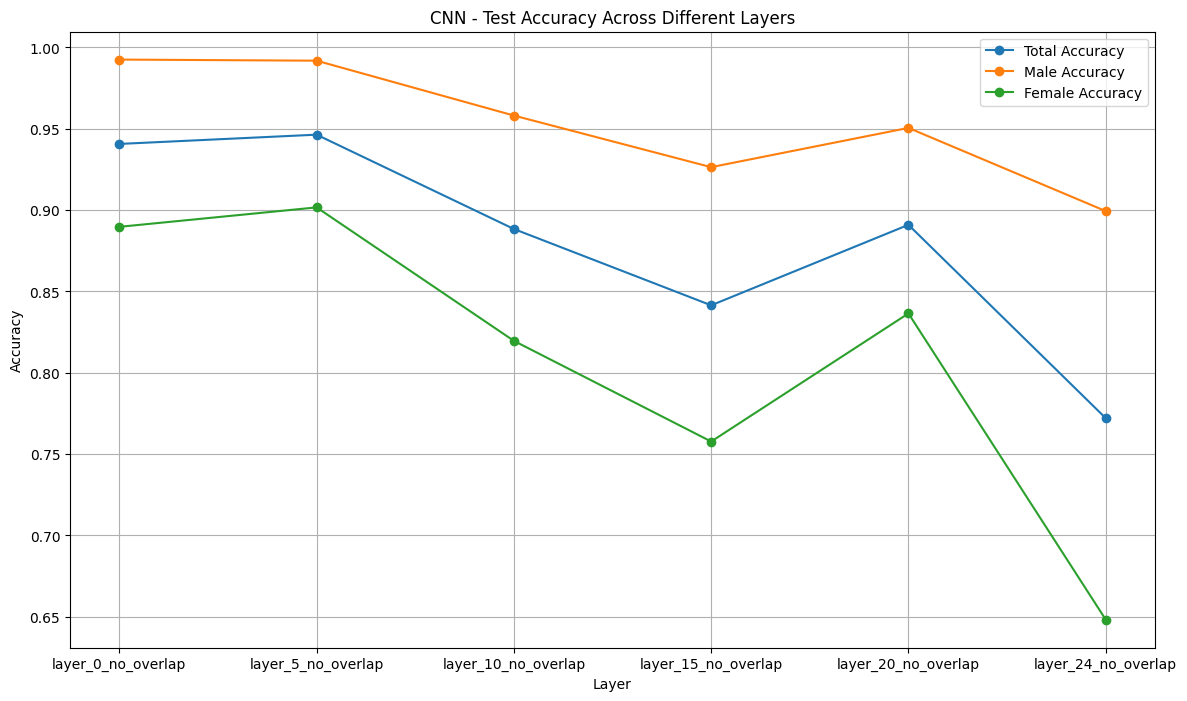

In [ ]:
from google.colab import drive

csv_path = '/content/drive/MyDrive/new_speaker_identification/evaluation/final_CNN_round/final_results.csv'

df = pd.read_csv(csv_path)

plt.figure(figsize=(14, 8))

# Plot für die Gesamtgenauigkeit
plt.plot(df['Layer'], df['Test Accuracy Total'], label='Total Accuracy', marker='o')

# Plot für die Genauigkeit der männlichen Sprecher
plt.plot(df['Layer'], df['Test Accuracy Male'], label='Male Accuracy', marker='o')

# Plot für die Genauigkeit der weiblichen Sprecher
plt.plot(df['Layer'], df['Test Accuracy Female'], label='Female Accuracy', marker='o')

plt.legend()
plt.title('CNN - Test Accuracy Across Different Layers')
plt.xlabel('Layer')
plt.ylabel('Accuracy')

plt.grid(True)

plt.show()

Evaluation logistische Regression

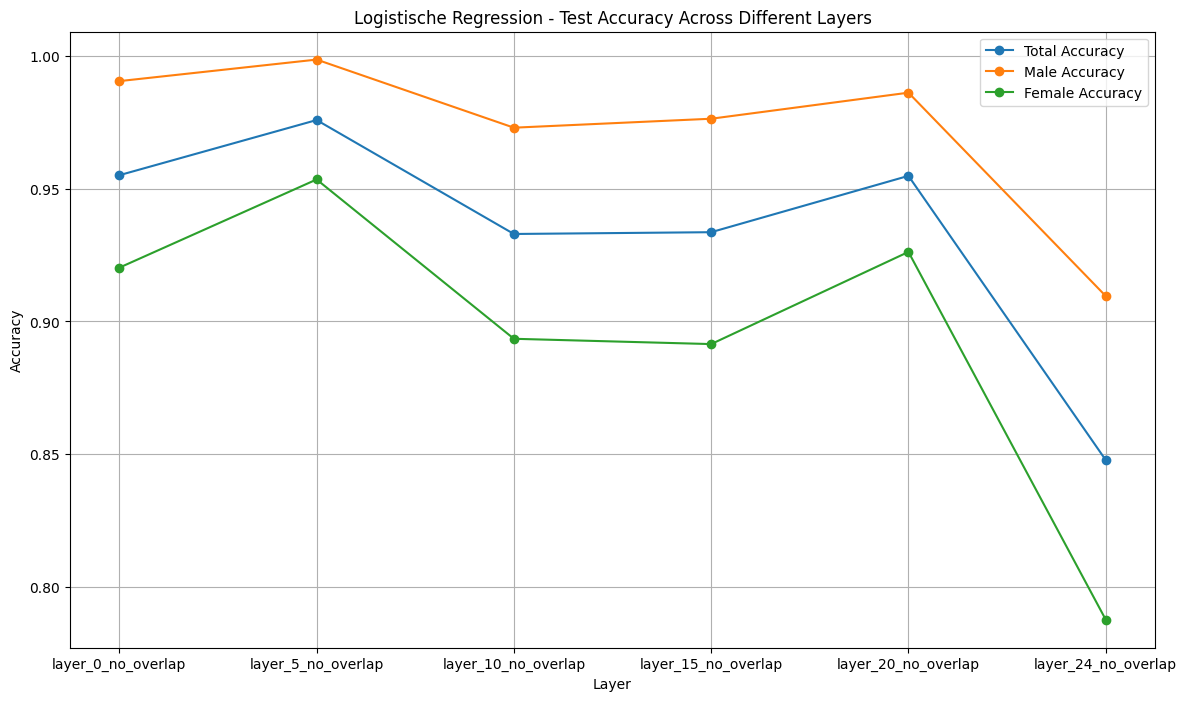

In [ ]:
csv_path = '/content/drive/MyDrive/new_speaker_identification/evaluation/LogReg/final_results.csv'

df = pd.read_csv(csv_path)

plt.figure(figsize=(14, 8))

# Plot für die Gesamtgenauigkeit
plt.plot(df['Layer'], df['Test Accuracy Total'], label='Total Accuracy', marker='o')

# Plot für die Genauigkeit der männlichen Sprecher
plt.plot(df['Layer'], df['Test Accuracy Male'], label='Male Accuracy', marker='o')

# Plot für die Genauigkeit der weiblichen Sprecher
plt.plot(df['Layer'], df['Test Accuracy Female'], label='Female Accuracy', marker='o')

plt.legend()
plt.title('Logistische Regression - Test Accuracy Across Different Layers')
plt.xlabel('Layer')
plt.ylabel('Accuracy')

plt.grid(True)

plt.show()

Both models show similary patterns and trends. The plots suggest, that the most information about the speaker could be encodet in the first 5 hidden states. Male speaker show a significant higher accuracy in recognition compared to female speaker. This finding should be further investigated. This could reflect the fact that the training data of the used XSL-R encoder could be uneven distributed in terms of gender.

- lets further investigate this theories in the literature.
